<a href="https://colab.research.google.com/github/Jeremy26/neural_optimization_course/blob/main/modelPruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Pruning Workshop!

In this workshop, we'll learn the concept of Pruning Neural Network models using Pytorch. We'll do the following tasks:
1. Download and use FashionMNIST dataset to setup our data pipeline.
2. Define a custom MLP model and calculate the `inference metrics` we learned in the previous workshop for the original model
3. Train the custom model on FashionMNIST dataset and record baseline `accuracy`
4. Learn different Pruning techniques in Pytorch and how to use them
5. Apply different Pruning techniques on the trained model
6. Compare metrics of the different pruned models

In [ ]:
!wget https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/modelPruning_content.zip && unzip -q modelPruning_content.zip && mv modelPruning_content/* ./ && rm modelPruning_content.zip && rm -rf modelPruning_content/

--2022-01-26 12:29:20--  https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/modelPruning_content.zip
Resolving optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)... 52.95.156.40
Connecting to optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)|52.95.156.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134975 (132K) [application/zip]
Saving to: ‘modelPruning_content.zip’

modelPruning_conten 100%[===================>] 131.81K   436KB/s    in 0.3s    

2022-01-26 12:29:21 (436 KB/s) - ‘modelPruning_content.zip’ saved [134975/134975]



### Basic Imports

In [ ]:
# basic imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm

# DL library imports
import torch

# torch Dataset required imports
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F

In [ ]:
def set_seed(seed : int):
    """Function to make results reproducible
    Args:
        seed (int): input seed
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(1)

## 1 — FashionMNIST Dataset & DataLoader


Here, we're going to use the FashionMNIST dataset for this case study.
- Fashion MNIST dataset is Zalando's collection of grayscale images of different apparels and their associated labels for Deep Learning research and development
- It consists of 60k train images and 10k test images, each of resolution 28 X 28 pixels
- The images contain integer values in range [0-255] and there are 10 labels. eg : 0 = T-shirt/top, 1 = Trouser, 2 = Pullover, 3 = Dress etc
- [Zalando FashionMNIST git repo](https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
datasetLabels = ['TShirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoot']

# necessary image transform i.e. convert to Tensor, normalize
trainTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])
testTransform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

# Download the Train and Test set
trainSet = datasets.FashionMNIST('.', train=True, download=True, transform=trainTransform)
testSet = datasets.FashionMNIST('.', train=False, download=True, transform=testTransform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
NUM_WORKERS = 1 
TEST_BATCH_SIZE  = 64
TRAIN_BATCH_SIZE = 16
VALID_SIZE = 0.2 

In [ ]:
lenTrainSet = len(trainSet)
indexList = list(range(lenTrainSet))
np.random.shuffle(indexList)
splitIndex = int(lenTrainSet * VALID_SIZE)
trainIndices, validIndices = indexList[splitIndex:], indexList[:splitIndex]

In [ ]:
trainSampler = SubsetRandomSampler(trainIndices)
validSampler = SubsetRandomSampler(validIndices)

trainLoader = DataLoader(trainSet, batch_size=TRAIN_BATCH_SIZE, sampler=trainSampler, num_workers=NUM_WORKERS)
validLoader = DataLoader(trainSet, batch_size=TEST_BATCH_SIZE,  sampler=validSampler, num_workers=NUM_WORKERS)
testLoader  = DataLoader(testSet,  batch_size=TEST_BATCH_SIZE,  shuffle=True,num_workers=NUM_WORKERS)

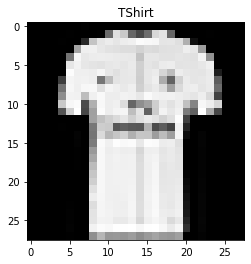

In [ ]:
# View sample from dataset
img, label = next(iter(trainLoader))
plt.imshow(img[0].numpy().squeeze(), cmap = 'Greys_r')
plt.title(f'{datasetLabels[label[0].item()]}')
plt.show()

## 2 — Define a custom MLP Classifier Model and calculate Inference metrics

- We'll use a simple feed forward model that takes in flattened image vector (28x28=784) and outputs probabilities for each of 10 classes.
- In Pytorch, we can create the Neural Network model by defining a custom class (inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)).
- The `forward` function in the class defines the forward pass of the network.

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128, bias=True)
        self.fc2 = nn.Linear(128, 64, bias=True)
        self.fc3 = nn.Linear(64, 32, bias=True)
        self.fc4 = nn.Linear(32, 10, bias=True)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

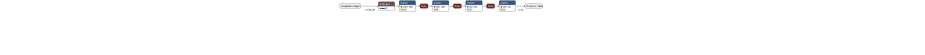

In [ ]:
from IPython.core.display import SVG, display
display(SVG(filename='images/MLP_classifier_FashionMNIST.svg'))

#### Print the Model Metrics

We'll use the functions used in the `metrics` notebook to print inference parameters of our custom model 

In [ ]:
# Load the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier().to(device)

In [ ]:
from scripts.modelMetrics import computeInferenceTime, getModelFileSize, profile, getModelSize

def print_model_metrics(model, input):
  print("-------------------")
  print("Model Size: ", str(round(getModelSize(model),3)),"Mb")
  print("File Size: ", str(round(getModelFileSize(model),3)),"Mb")
  print("Inference Time: ",str(round(computeInferenceTime(model,randomInput, device),5)),"s")
  macs, params = profile(model, inputs=(randomInput,), verbose=False)
  flops = 2 * macs
  print("Mega FLOPS: ", str(flops * 1e-6))
  print("Mega MACs: ", str(macs * 1e-6))
  print("Mega Params: ", str(params * 1e-6))


randomInput = torch.rand(2, 28, 28).to(device)
print_model_metrics(model, randomInput)

-------------------
Model Size:  0.424 Mb
File Size:  0.447 Mb
Inference Time:  0.00059 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


#### Print the Model Sparsity

- Model sparsity refers to the ratio of parameters with zero weights to the total number of parameters. 
- Eg : If a linear layer with 100 neurons and 25 of the neurons have been pruned (effectively set to zero) then the sparsity of the layer is 25%.
- Sparsity can be calculated for each layers and for the entire model as well (referred to as Global sparsity)


In [ ]:
def get_model_sparsity(model : nn.Module):
    """Function prints sparsity of the model - the percentage of weights with 0.0 in each layer of the model
    Args:
        model (nn.Module): input model
    """    
    print("Sparsity Information")    
    print("------------------------")
    totalElements = 0
    totalZeroElements = 0
    for name, module in model.named_children():
        #print(module.weight)
        numElementsInLayer = float(module.weight.nelement())
        numZeroElementsInLayer = float(torch.sum(module.weight == 0))
        layerWeightSparsity = 100.0 * (numZeroElementsInLayer/ numElementsInLayer)
        print(f"Sparsity in {name}.weight: {layerWeightSparsity}%.")
        
        totalElements += numElementsInLayer
        totalZeroElements += numZeroElementsInLayer
    
    if totalElements > 0 :
        globalWeightSparsity = 100.0 * (totalZeroElements / totalElements)
    else:
        globalWeightSparsity = 0.0
    return globalWeightSparsity
    

sparsity = get_model_sparsity(model)
print(f"Global Sparsity (weight): {sparsity}%")

Sparsity Information
------------------------
Sparsity in fc1.weight: 0.0%.
Sparsity in fc2.weight: 0.0%.
Sparsity in fc3.weight: 0.0%.
Sparsity in fc4.weight: 0.0%.
Global Sparsity (weight): 0.0%


- ***As expected, the original model has 0 sparsity***

### 3. Train the Model on FashionMNIST, record baseline accuracy

Before we train our model, we'll define some helper functions to calculate metric, plot training results etc

In [ ]:
## CLASSIFICATION ACCURACY AS METRIC FUNCTION

class meanClassificationAccuracyMetric:
    """
    Class to find the avg accuracy of softmax predictions to ground truth label
        CFG (Any): object containing num_classes 
        device (torch.device): compute device
    """    
    def __init__(self, CFG=None, device=None):
        self.batchAccuracies = []
        self.meanClassificationAccuracy = 0.0

    def update(self, y_preds: torch.Tensor, labels: torch.Tensor):
        """ Function finds the classification accuracy for the input batch

        Args:
            y_preds (torch.Tensor): model predictions
            labels (torch.Tensor): groundtruth labels        
        Returns
        """
        # predicted output class
        modelPredictions = np.argmax(torch.softmax(y_preds, axis=1).numpy(), axis=1)
        self.batchAccuracies.append(accuracy_score(labels.numpy(), modelPredictions))

    def compute(self):
        """ returns meanClassificationAccuracy """
        self.meanClassificationAccuracy = np.mean(self.batchAccuracies) * 100.0
        return self.meanClassificationAccuracy

    def reset(self):
        self.batchAccuracies = []
        self.meanClassificationAccuracy = 0.0

In [ ]:
## UTILITY FUNCTION TO PLOT TRAINING RESULTS

def plotTrainingResults(df:pd.DataFrame, modelName:str):
    """Function plots training, validation losses vs epoch
    Args:
        df (pd.DataFrame): Dataframe with the columns ['epoch', 'trainLoss', 'validationLoss']
        modelName (str): name of the model
    """   
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1_color = 'tab:red'
    ax1.set_ylabel('trainLoss', color=ax1_color)
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color=ax1_color)
    ax1.tick_params(axis='y', labelcolor=ax1_color)

    ax2 = ax1.twinx()  
    ax2_color = 'tab:blue'    
    ax2.set_ylabel('validationLoss', color=ax2_color)
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color=ax2_color)
    ax2.tick_params(axis='y', labelcolor=ax2_color)

    fig.tight_layout()
    plt.show()

In [ ]:
## TRAIN VALIDATE FUNCTION

def trainValidateModel(model, criterion, optimizer, dataloader_train, 
                       dataloader_valid, metricClass, metricName, device,
                       modelName):
    print("------------------------")
    print(f"Train Validate Pipeline for - {modelName} on {str(device)}")
    print("------------------------")
    results = []    
    minValidationLoss = np.Inf
    lenTrainLoader = len(dataloader_train)

    # move model to target device
    model.to(device)
    
    for epoch in range(N_EPOCHS):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        trainLoss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(dataloader_train), total=lenTrainLoader):
            inputs = inputs.to(device)
            labels = labels.to(device)  

            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            trainLoss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            
        # Validate
        model.eval()
        validationLoss = 0.0
        metricObject = metricClass(device=device)

        with torch.no_grad():
            for inputs, labels in dataloader_valid:
                inputs = inputs.to(device)
                labels = labels.to(device)                
                y_preds = model(inputs)
            
                # calculate loss
                loss = criterion(y_preds, labels)
                validationLoss += loss.item()

                # update batch metric information            
                metricObject.update(y_preds.cpu().detach(), labels.cpu().detach())

        # compute per batch losses
        trainLoss = trainLoss / len(dataloader_train)
        validationLoss = validationLoss / len(dataloader_valid)

        # compute metric
        validationMetric = metricObject.compute()

        print(f'Epoch: {epoch+1}, trainLoss:{trainLoss:6.5f}, validationLoss:{validationLoss:6.5f}, {metricName}:{validationMetric: 4.2f}%')
        
        # store results
        results.append({'epoch': epoch, 'trainLoss': trainLoss, 
                        'validationLoss': validationLoss, f'{metricName}': validationMetric})
        
        # if validation loss has decreased, save model and reset variable
        if validationLoss <= minValidationLoss:
            minValidationLoss = validationLoss
            torch.save(model.state_dict(), f'{modelName}.pt')

    # plot results
    results = pd.DataFrame(results)
    plotTrainingResults(results, f'{modelName}')

    return results

------------------------
Train Validate Pipeline for - Custom_MLP on cuda
------------------------
Starting 1 epoch ...


100%|██████████| 3000/3000 [00:41<00:00, 72.19it/s]


Epoch: 1, trainLoss:0.68065, validationLoss:0.62817, accuracy: 76.01%
Starting 2 epoch ...


100%|██████████| 3000/3000 [00:32<00:00, 90.97it/s]


Epoch: 2, trainLoss:0.56924, validationLoss:0.53861, accuracy: 81.15%
Starting 3 epoch ...


100%|██████████| 3000/3000 [00:33<00:00, 90.20it/s]


Epoch: 3, trainLoss:0.55530, validationLoss:0.62552, accuracy: 78.53%


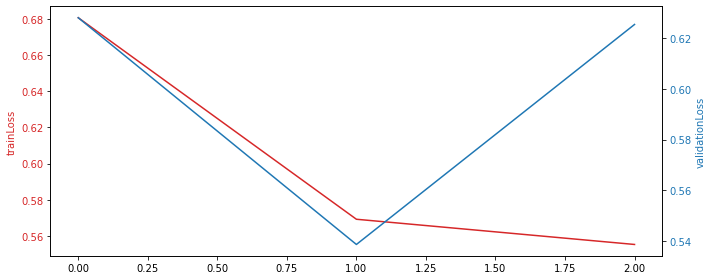

In [ ]:
# Hyper parameters for training model
N_EPOCHS = 3
LR = 1e-2

# Define the Loss
criterion = nn.CrossEntropyLoss()

# Define the Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# train, validate standard model
modelResults = trainValidateModel(model, criterion, optimizer, trainLoader, validLoader, meanClassificationAccuracyMetric, 'accuracy', device, "Custom_MLP")

In [ ]:
## UTILITY FUNCTION TO EVALUATE MODEL ON TEST SET
def evaluteOnTestData(model, pretrainedModelPath, device, 
                     dataloader_test, metricClass, metricName, modelName):

    # print("------------------------")
    # print(f"Test Data Results for {modelName} using {str(device)}")
    # print("------------------------")

    testSetMetric = 0.0
    
    modelLoadStatus = False
    if pretrainedModelPath is not None:
        if os.path.isfile(pretrainedModelPath) == True:
            model.load_state_dict(torch.load(pretrainedModelPath, map_location=device))
            modelLoadStatus = True
    # no need to load model
    else:
        modelLoadStatus = True

    if modelLoadStatus == True:
        lenTestLoader = len(dataloader_test)
        model.to(device)
        # set to inference mode
        model.eval()
        metricObject = metricClass(device=device)

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader_test, total=lenTestLoader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                y_preds = model(inputs)
            
                # update batch metric information            
                metricObject.update(y_preds.cpu().detach(), labels.cpu().detach())

        # compute metric of test set predictions
        testSetMetric = metricObject.compute()
        print(f'\n{modelName} has {testSetMetric} {metricName} on testData')

    else:
        print(f'Model cannot load state_dict from {pretrainedModelPath}')
    return testSetMetric

In [ ]:
testSetMetric = evaluteOnTestData(model, "./Custom_MLP.pt", device, testLoader, 
                    meanClassificationAccuracyMetric, "Test_Accuracy", "Custom_MLP")

100%|██████████| 157/157 [00:03<00:00, 45.73it/s]


Custom_MLP has 80.1453025477707 Test_Accuracy on testData


## 4. Learn different Pruning techniques in Pytorch


In [ ]:
# pruning header import
import torch.nn.utils.prune as prune

# pruning operations are done in-place, so take a copy of the model / module
from copy import deepcopy

# create a dummy module to understand pruning techniques
fc_test = nn.Linear(10,10)

module = deepcopy(fc_test)

Before pruning, we'll inspect the module parameters

In [ ]:
# contains `weight` and `bias` parameters
print('Before pruning, named_parameters()')
print(list(module.named_parameters()))

print('Before pruning, named_buffers()')
# prior to pruning contains no buffers
print(list(module.named_buffers()))

Before pruning, named_parameters()
[('weight', Parameter containing:
tensor([[ 0.2950,  0.2520,  0.0778,  0.0610,  0.2252,  0.1581,  0.0321, -0.2291,
         -0.0132, -0.1017],
        [-0.0696,  0.0357, -0.2342, -0.0112, -0.1979,  0.0146, -0.0983, -0.1648,
         -0.1094, -0.1549],
        [-0.0327,  0.1431, -0.0904,  0.0848,  0.3022,  0.0465,  0.2968, -0.0288,
          0.0441, -0.1095],
        [-0.1983,  0.1292,  0.0237,  0.2615,  0.1528,  0.1460, -0.3059,  0.0859,
          0.0044,  0.1624],
        [ 0.0965, -0.1191, -0.2815, -0.2946,  0.0046, -0.2745, -0.2245,  0.1769,
          0.1681, -0.2291],
        [ 0.2045, -0.2083, -0.2051,  0.2677,  0.1330, -0.0773, -0.3029, -0.2456,
         -0.2548,  0.1832],
        [ 0.2205, -0.1450,  0.0095,  0.1775,  0.1023,  0.1577, -0.0159,  0.2147,
          0.0376,  0.2460],
        [ 0.2935,  0.1356, -0.1321, -0.1462,  0.1315, -0.2623,  0.2768,  0.2142,
         -0.1593, -0.2209],
        [ 0.0331, -0.2156, -0.1278,  0.1049, -0.3136, -0.28

Let's apply `Unstructured Pruning` to the module

In [ ]:
# l1_unstructured means that weights are pruned according to their `L1_norm`
# eg: the following line prunes 30% of weights in module according to their L1 norm
prune.l1_unstructured(module, 'weight', amount=0.3);

Now, we'll inspect the module parameters after pruning

In [ ]:
# contains `weight_orig` and `bias` parameters
print('After pruning, named_parameters()')
print(list(module.named_parameters()))

# after pruning contains `weight_mask`
print('After pruning, named_buffers()')
print(list(module.named_buffers()))

After pruning, named_parameters()
[('bias', Parameter containing:
tensor([-0.2342, -0.3090,  0.1633,  0.0275,  0.0574,  0.0301, -0.1112,  0.0386,
        -0.2410,  0.1732], requires_grad=True)), ('weight_orig', Parameter containing:
tensor([[ 0.2950,  0.2520,  0.0778,  0.0610,  0.2252,  0.1581,  0.0321, -0.2291,
         -0.0132, -0.1017],
        [-0.0696,  0.0357, -0.2342, -0.0112, -0.1979,  0.0146, -0.0983, -0.1648,
         -0.1094, -0.1549],
        [-0.0327,  0.1431, -0.0904,  0.0848,  0.3022,  0.0465,  0.2968, -0.0288,
          0.0441, -0.1095],
        [-0.1983,  0.1292,  0.0237,  0.2615,  0.1528,  0.1460, -0.3059,  0.0859,
          0.0044,  0.1624],
        [ 0.0965, -0.1191, -0.2815, -0.2946,  0.0046, -0.2745, -0.2245,  0.1769,
          0.1681, -0.2291],
        [ 0.2045, -0.2083, -0.2051,  0.2677,  0.1330, -0.0773, -0.3029, -0.2456,
         -0.2548,  0.1832],
        [ 0.2205, -0.1450,  0.0095,  0.1775,  0.1023,  0.1577, -0.0159,  0.2147,
          0.0376,  0.2460],
    

In [ ]:
# EQUIVALENT NUMPY OPERATION IS AS FOLLOWS:
module = deepcopy(fc_test)
weight = module.weight.cpu().detach().numpy()
print(weight)
sorted_array = np.sort(np.abs(weight.ravel()))
print(sorted_array)
pruned_array = np.abs(weight) > sorted_array[29]
print(pruned_array.astype(int))

[[ 0.29501545  0.25199652  0.07775453  0.06098305  0.22517054  0.1580694
   0.03205344 -0.22909568 -0.01317724 -0.10166031]
 [-0.06955828  0.03566054 -0.23423316 -0.01121136 -0.19785859  0.01463118
  -0.09830224 -0.16480191 -0.10940243 -0.15494011]
 [-0.0327295   0.14311488 -0.09035267  0.08479156  0.3022364   0.04654382
   0.2967612  -0.02884566  0.04414692 -0.10950545]
 [-0.19825158  0.12920628  0.02369685  0.26149327  0.15277907  0.14600156
  -0.30585152  0.08589599  0.00437141  0.16243252]
 [ 0.09648319 -0.11909986 -0.2814593  -0.2945941   0.00464906 -0.27450764
  -0.22452131  0.17686082  0.16805485 -0.22912803]
 [ 0.20453869 -0.20827411 -0.20512632  0.26774517  0.13304639 -0.07731389
  -0.30291587 -0.2456031  -0.2547661   0.18318796]
 [ 0.22047074 -0.14501871  0.0094866   0.17747332  0.10230964  0.1576576
  -0.01588311  0.21471108  0.03763908  0.24595214]
 [ 0.29350516  0.13560781 -0.1321434  -0.14615607  0.13148957 -0.26229444
   0.27675223  0.21416323 -0.15934224 -0.22087573]
 [

- As you can see, the `weight` in named_parameters() has been replaced by `weight_mask` and a new `weight_mask` has been added to named_buffers()

- API for structured Pruning is also similiar as seen below

In [ ]:
import torch.nn.utils.prune as prune

module = nn.Linear(10,10)
prune.ln_structured(module, 'weight', amount=0.3, n=1, dim=0);

In [ ]:
module = deepcopy(fc_test)
# n denotes the order of `L-norm` to use while pruning
# dim indicates which dimension to prune
prune.ln_structured(module, 'weight', amount=0.3, n=1, dim=0);

In [ ]:
# We can observe entire rows of weights are set to zero, meaning all 
# connections to a neuron have been pruned
list(module.named_buffers())

[('weight_mask', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))]

In [ ]:
# EQUIVALENT NUMPY OPERATION IS AS FOLLOWS:

module = deepcopy(fc_test)

weight = module.weight.cpu().detach().numpy()
print(weight)

# finding the L1 norm for each row (equivalent to 
# total norm of each neuron) and sort them 
sorted_array = np.argsort(np.sum(np.abs(weight), axis=1))
print(sorted_array)

pruned_array = np.ones_like(weight)

# prune 30% (=3rows) with lowest L1 norm
pruned_array[sorted_array[0:3], :] = 0
print(pruned_array.astype(int))

[[ 0.29501545  0.25199652  0.07775453  0.06098305  0.22517054  0.1580694
   0.03205344 -0.22909568 -0.01317724 -0.10166031]
 [-0.06955828  0.03566054 -0.23423316 -0.01121136 -0.19785859  0.01463118
  -0.09830224 -0.16480191 -0.10940243 -0.15494011]
 [-0.0327295   0.14311488 -0.09035267  0.08479156  0.3022364   0.04654382
   0.2967612  -0.02884566  0.04414692 -0.10950545]
 [-0.19825158  0.12920628  0.02369685  0.26149327  0.15277907  0.14600156
  -0.30585152  0.08589599  0.00437141  0.16243252]
 [ 0.09648319 -0.11909986 -0.2814593  -0.2945941   0.00464906 -0.27450764
  -0.22452131  0.17686082  0.16805485 -0.22912803]
 [ 0.20453869 -0.20827411 -0.20512632  0.26774517  0.13304639 -0.07731389
  -0.30291587 -0.2456031  -0.2547661   0.18318796]
 [ 0.22047074 -0.14501871  0.0094866   0.17747332  0.10230964  0.1576576
  -0.01588311  0.21471108  0.03763908  0.24595214]
 [ 0.29350516  0.13560781 -0.1321434  -0.14615607  0.13148957 -0.26229444
   0.27675223  0.21416323 -0.15934224 -0.22087573]
 [

### *Plot the Pruning results*

In [ ]:
def plot_fc_weight(weight, ax=None, cmap='viridis'):
  nrows, ncols = weight.shape
  x = np.arange(0,ncols)
  y = np.arange(0,nrows)
  X, Y = np.meshgrid(x,y)
  z_np = weight.detach().cpu().numpy()
  ln = ax.pcolor(X, Y, z_np, cmap=cmap)
  ax.axis('off')
  return ln

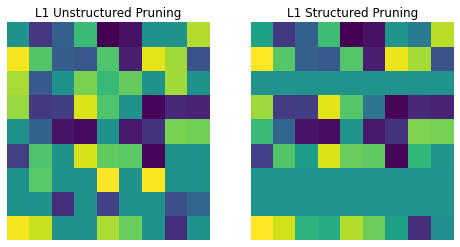

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 4))
plot_fc_weight(module.weight, ax1)

# l1 unstructured pruning
module = deepcopy(fc_test)
prune.l1_unstructured(module, 'weight', amount=0.3);
plot_fc_weight(module.weight, ax1);
ax1.set_title('L1 Unstructured Pruning')

# l1 Structured pruning
module = deepcopy(fc_test)
prune.ln_structured(module, 'weight', amount=0.3, n=1, dim=0);
plot_fc_weight(module.weight, ax2);
ax2.set_title('L1 Structured Pruning');

## 5. Apply different Pruning techniques on our custom model

Now that we understand the pruning APIs in Pytorch, we'll use them to 
prune our custom MLP model. In the next section, we'll do the following:

- Apply the Unstructured pruning we learned above and also the Global version of it along with structured pruning on our trained model
- Observe the Accuracy of both the pruned model on Test set
- Apply different levels of Pruning percentages (*read sparsity levels*) and observe the different in performance metric

In [ ]:
# Let's use different pruning percentages for each technique
prunePercentages = np.linspace(0.05, 0.90, 8).tolist()
print([round(x,3) for x in prunePercentages])

[0.05, 0.171, 0.293, 0.414, 0.536, 0.657, 0.779, 0.9]



### Layer wise Unstructured Pruning

In [ ]:
def layer_unstructured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=prunePercentage)
    return model

# placeholder to store results
l1_unstructured_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./Custom_MLP.pt"))

    # prune the model
    unStructuredPruneModel = layer_unstructured_prune(model, perc)

    # evaluate the pruned model on test data
    l1_unstructured_accuracies.append(evaluteOnTestData(unStructuredPruneModel, None, \
          device, testLoader, meanClassificationAccuracyMetric, "Test accuracy", "Unstructured Prune"))    

100%|██████████| 157/157 [00:03<00:00, 43.85it/s]



Unstructured Prune has 80.19506369426752 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.66it/s]



Unstructured Prune has 79.89649681528662 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 39.89it/s]



Unstructured Prune has 79.468550955414 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 39.94it/s]



Unstructured Prune has 79.37898089171973 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 44.77it/s]



Unstructured Prune has 80.83200636942675 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 44.54it/s]



Unstructured Prune has 73.61664012738854 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 44.79it/s]



Unstructured Prune has 14.769108280254779 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 44.85it/s]


Unstructured Prune has 16.261942675159236 Test accuracy on testData


## Layerwise structured pruning

In [ ]:
def layer_structured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.ln_structured(module, name='weight', amount=prunePercentage, n=1, dim=0)
    return model


# placeholder to store results
l1_structured_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./Custom_MLP.pt"))

    # prune the model
    structuredPruneModel = layer_structured_prune(model, perc)

    # evaluate the pruned model on test data
    l1_structured_accuracies.append(evaluteOnTestData(structuredPruneModel, None, \
          device, testLoader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune"))

100%|██████████| 157/157 [00:03<00:00, 44.84it/s]



structured Prune has 80.17515923566879 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.25it/s]



structured Prune has 70.75039808917197 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 44.34it/s]



structured Prune has 56.041003184713375 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.00it/s]



structured Prune has 55.91162420382165 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.77it/s]



structured Prune has 36.82324840764331 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.57it/s]



structured Prune has 27.10987261146497 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.91it/s]



structured Prune has 18.441480891719745 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.89it/s]


structured Prune has 15.714570063694266 Test accuracy on testData


### Global Unstructured Pruning

In [ ]:
def global_unstructured_prune(model:nn.Module, prunePercentage:float):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prunePercentage)
    return model


# placeholder to store results
global_prune_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./Custom_MLP.pt"))

    # prune the model
    globalPruneModel = global_unstructured_prune(model, perc)

    # evaluate the pruned model on test data
    global_prune_accuracies.append(evaluteOnTestData(globalPruneModel, None, \
          device, testLoader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune"))    

100%|██████████| 157/157 [00:03<00:00, 44.87it/s]



structured Prune has 80.21496815286623 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 44.47it/s]



structured Prune has 80.20501592356688 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.49it/s]



structured Prune has 79.63773885350318 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 44.65it/s]



structured Prune has 78.8515127388535 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.13it/s]



structured Prune has 80.51353503184714 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.33it/s]



structured Prune has 44.327229299363054 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 44.75it/s]



structured Prune has 12.937898089171975 Test accuracy on testData


100%|██████████| 157/157 [00:03<00:00, 45.74it/s]


structured Prune has 10.051751592356688 Test accuracy on testData


### 6. Compare metrics of different Pruned models

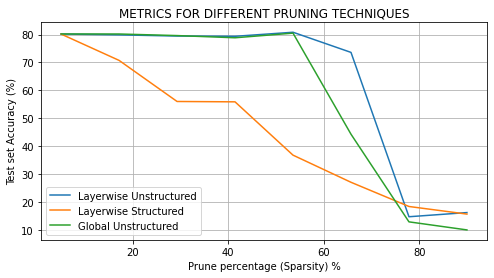

In [ ]:
# plot results
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_unstructured_accuracies), label='Layerwise Unstructured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_structured_accuracies), label='Layerwise Structured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(global_prune_accuracies), label='Global Unstructured')
ax.set(xlabel ='Prune percentage (Sparsity) %', ylabel = 'Test set Accuracy (%)', \
       title = 'METRICS FOR DIFFERENT PRUNING TECHNIQUES')
ax.legend()
ax.grid(True)
plt.show()

### Observations

 - We can observe that even at ~55% Sparsity, layer wise unstructured pruning techniques maintain roughly 80% test accuracy.
 - Beyond a threshold (60% in our case), test accuracy drops significantly for all 3 techniques indicating the model is not able to capture enough information with the remaining weights
 - At least in our case, structured pruning is worse than unstructured pruning. 

#### ***Optional task, plot all 4 layers of our custom model and see how different techiques have pruned weights***

In [ ]:
def plot_custom_model(model, title=''):
  fig, axes = plt.subplots(1,4,figsize=(16, 4), gridspec_kw={'width_ratios': [7,5,3,1]})
  plot_fc_weight(model.fc1.weight, axes[0])
  plot_fc_weight(model.fc2.weight, axes[1])
  plot_fc_weight(model.fc3.weight, axes[2])
  plot_fc_weight(model.fc4.weight, axes[3])
  
  axes[0].set_title('FC Layer1')
  axes[1].set_title('FC Layer2')
  axes[2].set_title('FC Layer3')
  axes[3].set_title('FC Layer4')
  
  if title is not '':
    plt.suptitle(title)

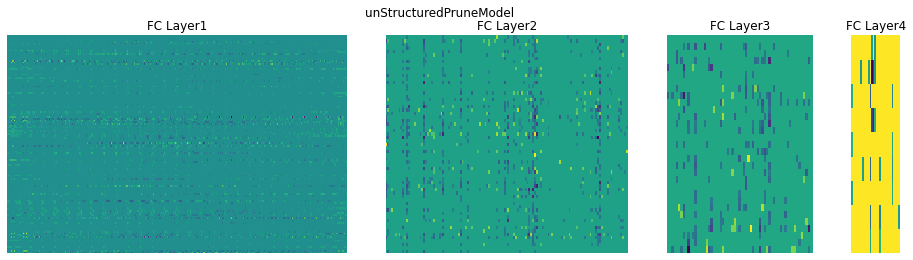

In [ ]:
plot_custom_model(unStructuredPruneModel, title='unStructuredPruneModel')

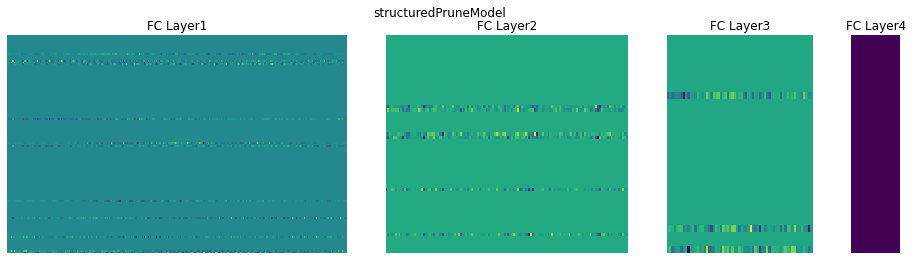

In [ ]:
plot_custom_model(structuredPruneModel, title='structuredPruneModel')

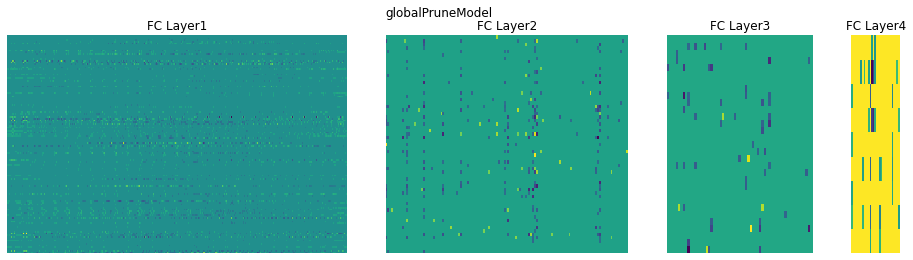

In [ ]:
plot_custom_model(globalPruneModel, 'globalPruneModel')

### Notes —

Now that we pruned majority of our model, what performance improvement can we expect?

- For now, ***Pytorch pruning doesn't improve the runtime performance of the model. This is because, even though large percentage of weights can be set to zero, the forward pass still uses operations on the entire dense tensors of the model***
- ***Sparse tensor operations functionality is still very limited in Pytorch, but it has plans to incorporate optimizations to see effects of Pruning in production systems***
- To truly see the effect of the different pruning methods, we need to use a separate library that can optimize the model for pruned weights and apply it to production or recreate the pruned model structure from scratch